In [1]:
import re
import os.path
import numpy as np
import pandas as pd
from datetime import datetime
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm
tqdm.pandas()
# for natural language processing
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from PIL import Image

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

# DATA Path for BeerAdvocate
DATA_FOLDER = 'Data/BeerAdvocate/'
BEER_BA_DATA = DATA_FOLDER+"beers.csv"
BREWERY_BA_DATA = DATA_FOLDER+"breweries.csv"
USERS_BA_DATA = DATA_FOLDER+"users.csv"
REVIEWS_BA_DATA = DATA_FOLDER+"reviews.txt.gz"
RATINGS_BA_DATA = DATA_FOLDER+"ratings.txt.gz"

# DATA Path for RateBeer
DATA_FOLDER2 = 'Data/RateBeer/'
BEER_RB_DATA = DATA_FOLDER2+"beers.csv"
BREWERY_RB_DATA = DATA_FOLDER2+"breweries.csv"
USERS_RB_DATA = DATA_FOLDER2+"users.csv"
REVIEWS_RB_DATA = DATA_FOLDER2+"reviews.txt.gz"

COMPRESSION = 'gzip'


# Milestone 2

## First look at the data

### beer.csv

In [2]:
# BeerAdvovate
beer_ba = pd.read_csv(BEER_BA_DATA)
beer_ba = beer_ba.set_index('beer_id')
beer_ba.head(2)

,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
beer_id,,,,,,,,,,,,,,
166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN


In [3]:
# RateBeer
beer_rb = pd.read_csv(BEER_RB_DATA)
beer_rb = beer_rb.set_index('beer_id')
beer_ba.head(2)

,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
beer_id,,,,,,,,,,,,,,
166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN


### brewery.csv

In [4]:
# BeerAdvocate
breweries_ba = pd.read_csv(BREWERY_BA_DATA)
breweries_ba.head()

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2


In [5]:
# RateBeer
users_ba = pd.read_csv(USERS_BA_DATA)
users_ba.head()

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland


### review.txt
The files are 2.7Go and 3.95Go '.txt'. It is quite hard to handle this way, therefore we performed preprocessing of the data once and then saved the dataframe in '.pkl' to be handled more easily.

In [2]:
labels = ['beer_name','beer_id','brewery_name','brewery_id','style','abv','date',
          'user_name','user_id','appearance','aroma','palate','taste','overall','rating','text']

# if code never ran, load each line of the .txt as a line in a dataframe

# BeerAdvocate
if os.path.isfile('Data/BeerAdvocate/review_ba.pkl')!=1:
    raw_review_data_ba = pd.read_csv(REVIEWS_BA_DATA, sep='\r',engine='python',header=None, compression = COMPRESSION)
    raw_review_data_ba.columns = ['lines']
    raw_review_data_ba.head(3)
    
# RateBeer
if os.path.isfile('Data/RateBeer/review_rb.pkl')!=1:
    raw_review_data_rb = pd.read_csv(REVIEWS_RB_DATA, sep='\r',engine='python',header=None, compression = COMPRESSION)
    raw_review_data_rb.columns = ['lines']
    raw_review_data_rb.head(3)

In [3]:
# looks at dataframe, check whether the first word corresponds to the name given in input
# It stores values in a output df with index as order of appearance
# Called in a loop it reconstruct the df with the right colomns iterratively

def new_column(name, data, df):
    buffer = pd.DataFrame()
    
    # takes line with fist word = name
    buffer[name] = data.loc[data['lines'].str.slice(0,len(name)).str.contains(name, case=False)]
    
    data = data.drop(buffer[name].index) #drops treated lines from the given df to reduce next iterations
    buffer.reset_index(inplace=True)     #resets index of selected lines to merge them with the new df
    df[name] = buffer[name].str[len(name)+1:] #removes column name from each data
    
    del buffer # Clear memory from uneccessary df
    return df, data

In [74]:
# BeerAdvocate
if os.path.isfile('Data/BeerAdvocate/review_ba.pkl')!=1:
    review_ba = pd.DataFrame()
    
    # from the raw data iterate to reconstruct clean df
    for name in labels:
        review_ba, raw_reviews_data_ba = new_column(name, raw_reviews_data_ba, review_ba)
        
    # Convert date to datetime
    review_ba['date'] = pd.to_datetime(review_ba['date'], format='%Y-%m-%d')
    
    # Save review in pickle format for efficiency
    review_ba.to_pickle('Data/BeerAdvocate/review_ba.pkl')
    
    # Clear memory from uneccessary df
    del raw_reviews_data_ba
    
else: #if code above was already ran once
    review_ba = pd.read_pickle('Data/BeerAdvocate/review_ba.pkl')
review_ba.head(3)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with..."
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,stjamesgate.163714,3.0,3.5,3.5,4.0,3.5,3.67,Pours pale copper with a thin head that quick...
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,mdagnew.19527,4.0,3.5,3.5,4.0,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim...."


In [4]:
# RateBeer
if os.path.isfile('Data/RateBeer/review_rb.pkl')!=1:
    review_rb = pd.DataFrame()
    
    # from the raw data iterate to reconstruct clean df
    for name in labels:
        review_rb, raw_reviews_data_rb = new_column(name, raw_reviews_data_rb, review_rb)
        
    # Convert date to datetime
    # review_rb['date'] = pd.to_datetime(review_rb['date'], format='%Y-%m-%d')
    
    # Save review in pickle format for efficiency
    review_rb.to_pickle('Data/RateBeer/review_rb.pkl')
    
    # Clear memory from uneccessary df
    del raw_reviews_data_rb
    
else: #if code above was already ran once
    review_rb = pd.read_pickle('Data/RateBeer/review_rb.pkl')
review_rb.head(3)

MemoryError: Unable to allocate 706. MiB for an array with shape (92586962,) and data type uint64

## Basic analysis

### Counts:

In [10]:
# BeerAdvocate
print("BeerAdvocate")
print(f"Number of beer styles: {review_ba['style'].nunique()}")
print(f"Number of breweries: {review_ba['brewery_id'].nunique()}")
print(f"Number of beers: {review_ba['beer_id'].nunique()}")
print(f"Number of users: {review_ba['user_id'].nunique()}")
print(f"Number of users: {review_ba['user_id'].nunique()}")
print(f"Timespan of datas: {review_ba['date'].max()-review_ba['date'].min()}")
print(f"Number of NaNs: {review_ba.isnull().sum().sum()}")

BeerAdvocate
Number of beer styles: 104
Number of breweries: 11968
Number of beers: 166649
Number of users: 62252
Number of users: 62252
Timespan of datas: 7649 days 00:00:00
Number of NaNs: 0


In [11]:
# RateBeer
print("\nRateBeer:")
print(f"Number of beer styles: {review_rb['style'].nunique()}")
print(f"Number of breweries: {review_rb['brewery_id'].nunique()}")
print(f"Number of beers: {review_rb['beer_id'].nunique()}")
print(f"Number of users: {review_rb['user_id'].nunique()}")
print(f"Number of users: {review_rb['user_id'].nunique()}")
print(f"Timespan of datas: {review_rb['date'].max()-review_rb['date'].min()}")
print(f"Number of NaNs: {review_rb.isnull().sum().sum()}")


RateBeer:
Number of beer styles: 93
Number of breweries: 21832
Number of beers: 396690
Number of users: 70121
Number of users: 70121
Timespan of datas: 6319 days 00:00:00
Number of NaNs: 0


### Number of reviews per users
Boxplot are plot without outliers as the data is very skewed to toward low number of reviews

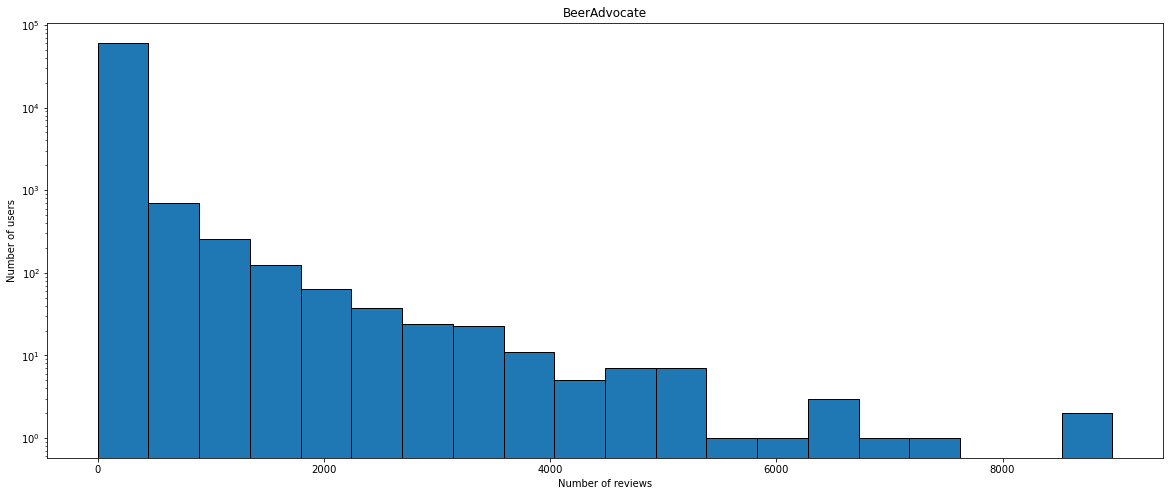

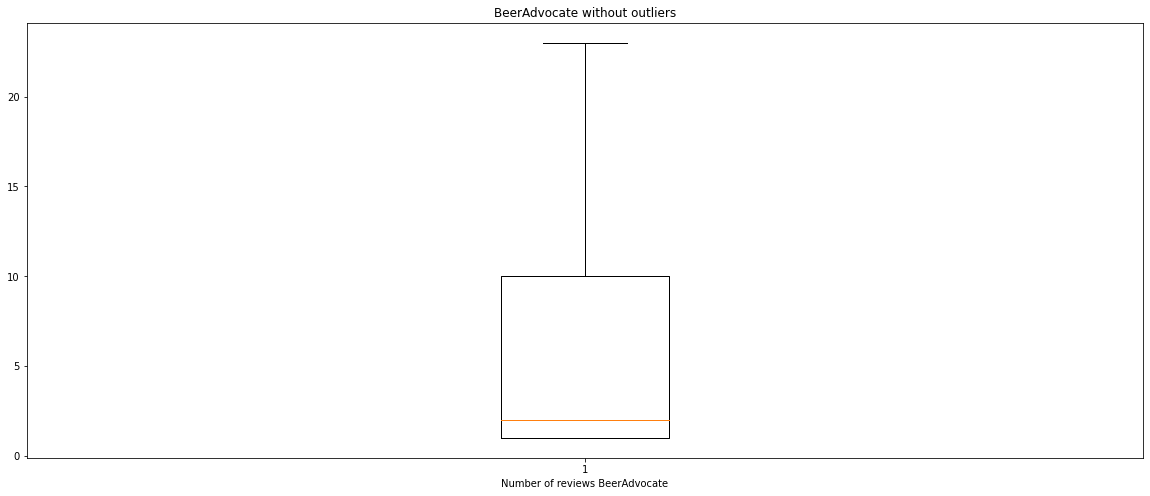

In [12]:
# BeerAdvocate
count_ba = review_ba.groupby(['user_id'])['text'].count().reset_index(name='Count').sort_values(['Count'],
                                                                                                ascending=False)
# Histogram
plt.rcParams["figure.figsize"] = (20,8)
plt.hist(count_ba['Count'],log=True, bins=20, edgecolor='black')
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')
plt.title('BeerAdvocate')
plt.show()

# Boxplot
plt.boxplot(count_ba['Count'], showfliers=False)
plt.xlabel('Number of reviews BeerAdvocate')
plt.title('BeerAdvocate without outliers')
plt.show()

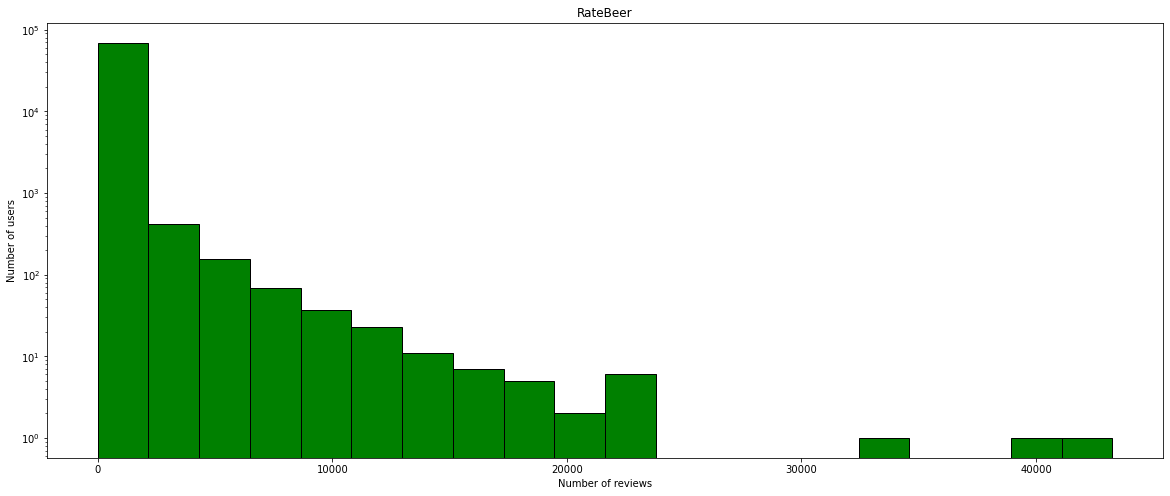

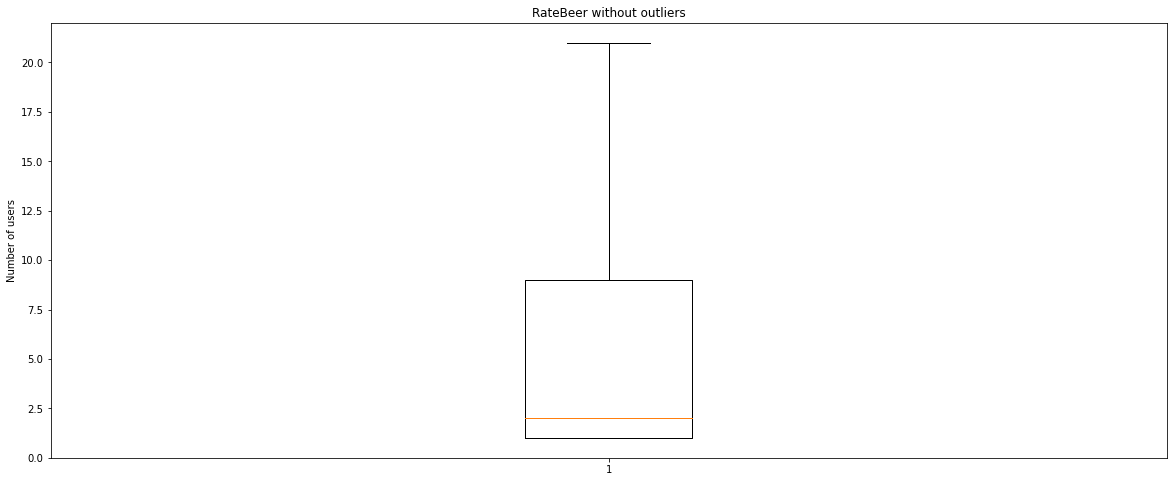

In [13]:
# RateBeer
count_rb = review_rb.groupby(['user_id'])['text'].count().reset_index(name='Count').sort_values(['Count'],
                                                                                                ascending=False)
# Histogram
plt.hist(count_rb['Count'],log=True, bins=20, edgecolor='black', color='green')
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')
plt.title('RateBeer')
plt.show()

# Boxplot
plt.boxplot(count_rb['Count'], showfliers=False)
plt.ylabel('Number of users')
plt.title('RateBeer without outliers')
plt.show()

#### Number of reviews per beer style

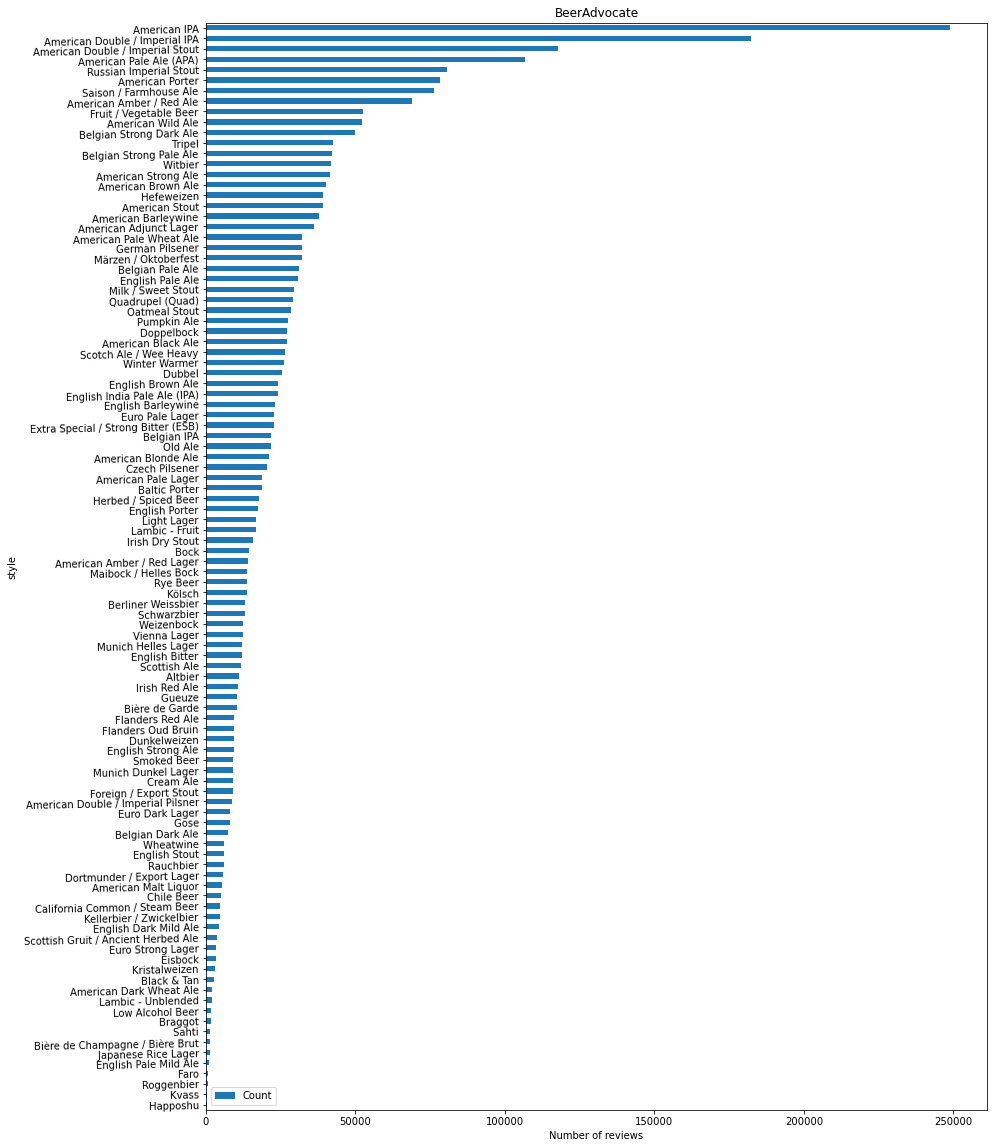

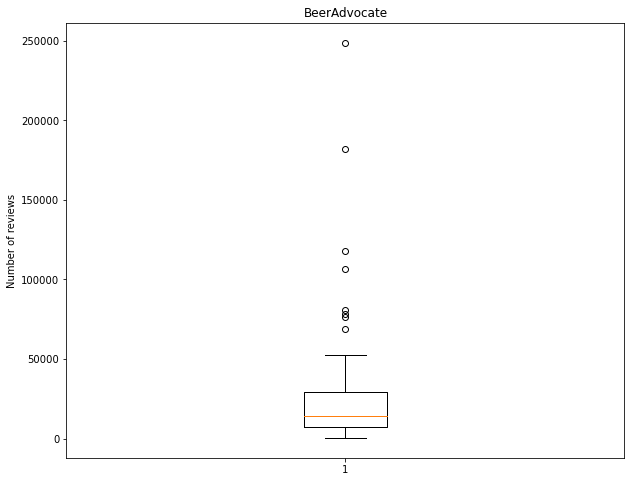

In [14]:
# BeerAdvocate

# counts number of beers per style
best_beers_ba = review_ba.groupby(['style'])['text'].count().reset_index(name='Count').sort_values(['Count'],
                                                                                                   ascending=True)
# Bar Plot
plt.rcParams["figure.figsize"] = (14,20)
best_beers_ba.plot.barh(x='style',rot=1)
plt.xlabel('Number of reviews')
plt.title('BeerAdvocate')
plt.show()

# Boxplot
plt.rcParams["figure.figsize"] = (10,8)
plt.boxplot(best_beers_ba['Count'])
plt.ylabel('Number of reviews')
plt.title('BeerAdvocate')
plt.show()

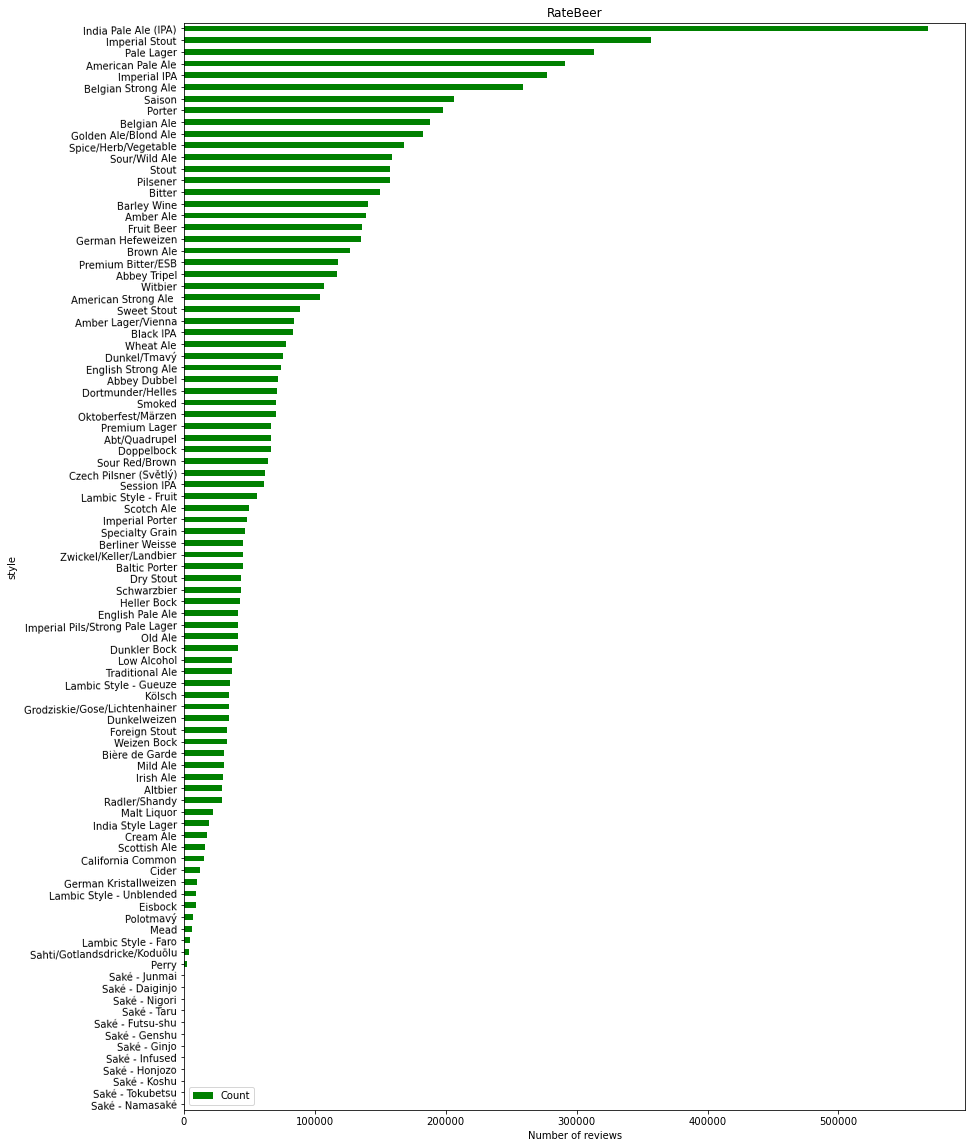

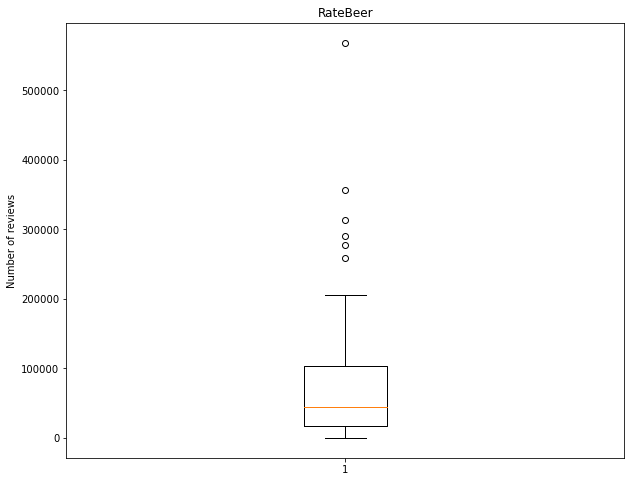

In [15]:
# RateBeer

# counts number of beers per style
best_beers_rb = review_rb.groupby(['style'])['text'].count().reset_index(name='Count').sort_values(['Count'],
                                                                                                   ascending=True)
# Bar Plot
plt.rcParams["figure.figsize"] = (14,20)
best_beers_rb.plot.barh(x='style',rot=1, color='green')
plt.xlabel('Number of reviews')
plt.title('RateBeer')
plt.show()

# Boxplot
plt.rcParams["figure.figsize"] = (10,8)
plt.boxplot(best_beers_rb['Count'])
plt.ylabel('Number of reviews')
plt.title('RateBeer')
plt.show()

#### Removing Datas lower than Q1
We decided to remove beer style with very low number of reviews as we do not have enough data to analyse

In [16]:
# BeerAdvocate
Q1_ba = np.percentile(best_beers_ba['Count'], 25, interpolation = 'midpoint') #finds Q1
out_ba = best_beers_ba[best_beers_ba['Count']<Q1_ba]['style']                 #finds beer style under Q1 reviews
review_ba = review_ba.drop(review_ba[review_ba['style'].isin(out_ba)].index)
review_ba.reset_index() #reset index to prevent issues with missing rows

print(f"BeerAdvocate: {out_ba.nunique()} styles where removed because they had less than {Q1_ba} reviews")

BeerAdvocate: 26 styles where removed because they had less than 6710.5 reviews


In [17]:
# RateBeer
Q1_rb = np.percentile(best_beers_rb['Count'], 25, interpolation = 'midpoint') #finds Q1
out_rb = best_beers_rb[best_beers_rb['Count']<Q1_rb]['style']                 #finds beer style under Q1 reviews
review_rb = review_rb.drop(review_rb[review_rb['style'].isin(out_rb)].index)
review_rb.reset_index() #reset index to prevent issues with missing rows

print(f"RateBeer: {out_rb.nunique()} styles where removed because they had less than {Q1_rb} reviews")

RateBeer: 23 styles where removed because they had less than 17916.0 reviews


## Reviews through time:

### Repartition on review per beer style

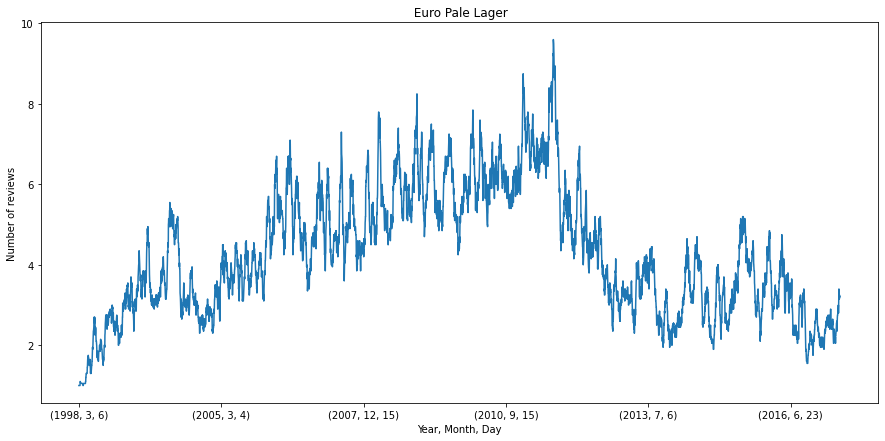

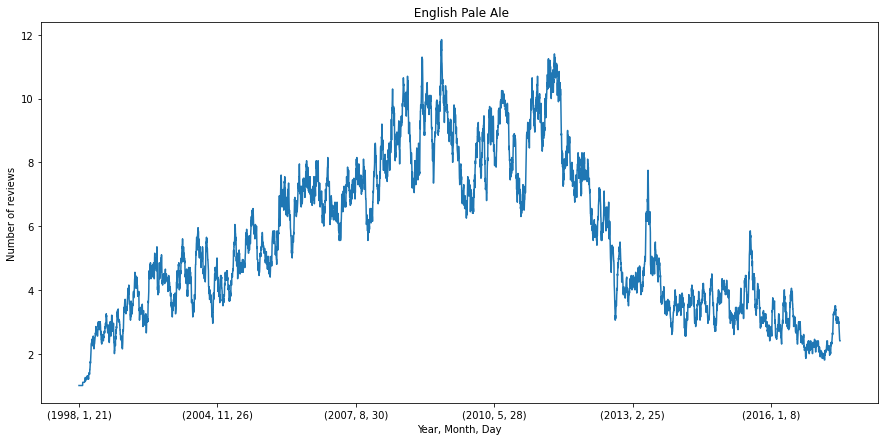

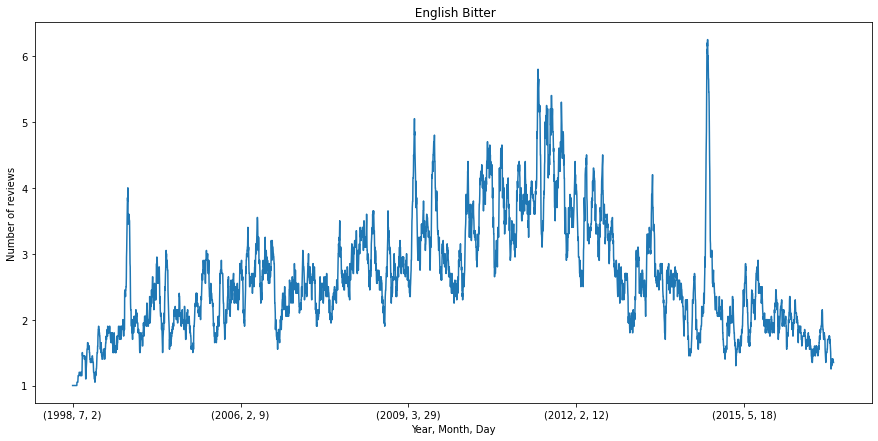

In [71]:
# BeerAdvocate
plt.rcParams["figure.figsize"] = (15,7)
styles_ba = review_ba['style'].unique() # finds each beer style

for j in range(3):
    beer = review_ba[(review_ba['style'] == styles_ba[j])]  # gets reviews of the given style
    
    # groups reviews per day of each year
    grouped = beer.groupby([beer['date'].dt.year,beer['date'].dt.month, beer['date'].dt.day])['user_name'].count()
    grouped.rolling(20, min_periods=1).mean().plot() #plots moving average to limit noise
    plt.title(styles_ba[j])
    plt.ylabel('Number of reviews')
    plt.xlabel('Year, Month, Day')
    plt.show()

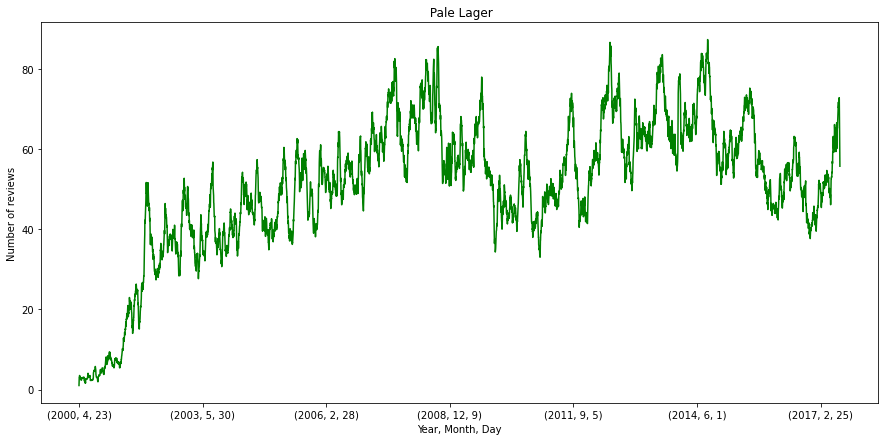

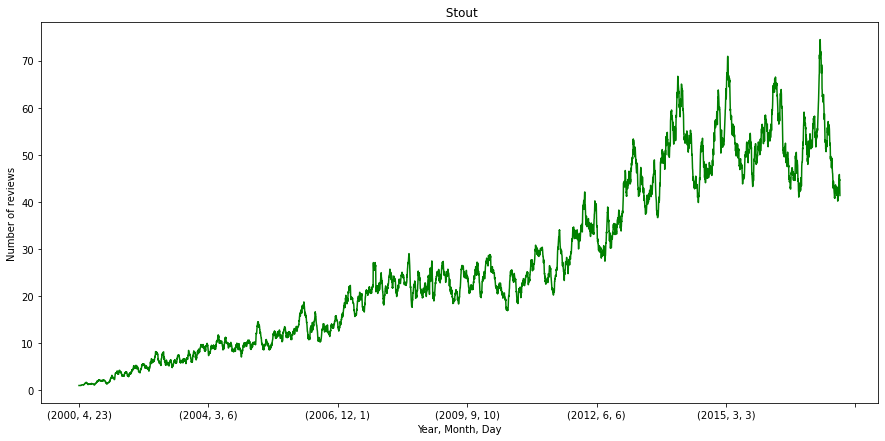

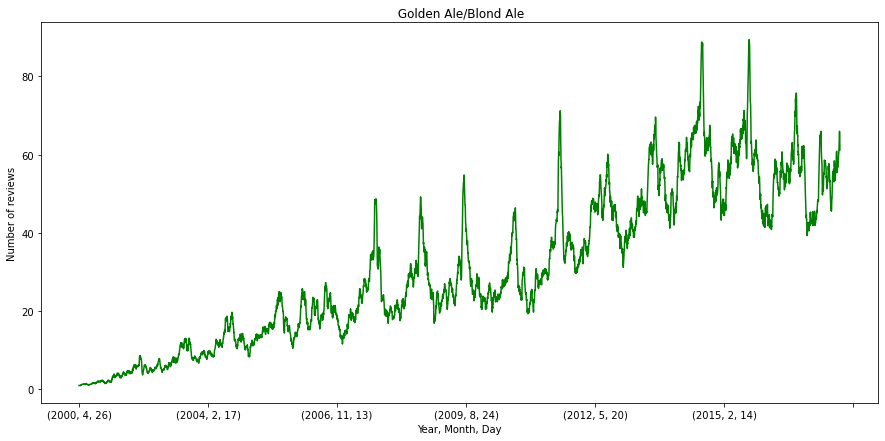

In [19]:
# RateBeer

styles_rb = review_rb['style'].unique() # finds each beer style

for j in range(3):
    beer = review_rb[(review_rb['style'] == styles_rb[j])]  # gets reviews of the given style
    
    # groups reviews per day of each year
    grouped = beer.groupby([beer['date'].dt.year,beer['date'].dt.month, beer['date'].dt.day])['user_name'].count()
    grouped.rolling(20, min_periods=1).mean().plot() #plots moving average to limit noise

plt.ylabel('Number of reviews')
plt.xlabel('Year, Month, Day')
plt.legend(styles_rb)
plt.title("Reviews through time example")
plt.show()

From the values above we can have a first glimpse at seasonality (Golden Ale/Blond Ale).

<strong>But how can we define a metric of seasonality to compare beers ?</strong>

# Milestone 3

## Seasonal repartition of beer styles:
### First method : repartition on review per beer style regrouped by month


(sensible to variation of yearly consumption)

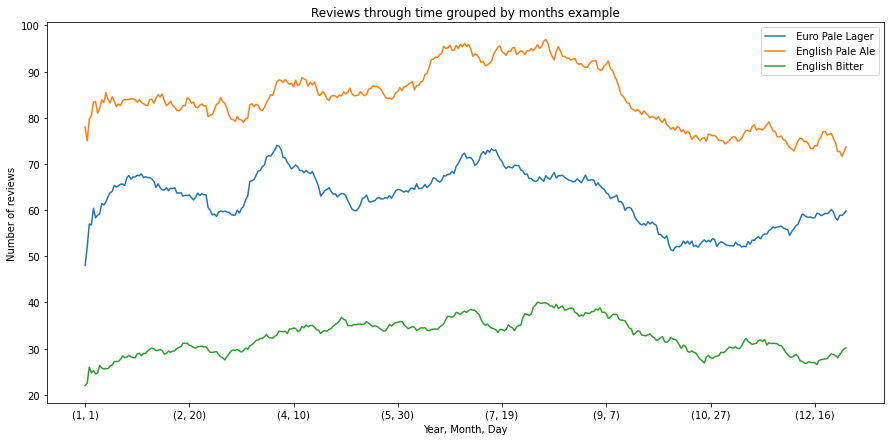

In [19]:
# BeerAdvocate
for j in range(3):
    beer = review_ba[(review_ba['style'] == styles_ba[j])] # gets reviews of the given style
    
    # groups reviews of each years together day by day
    grouped = beer.groupby([beer['date'].dt.month, beer['date'].dt.day])['user_name'].count()
    grouped.rolling(20, min_periods=1).mean().plot() #moving average


plt.ylabel('Number of reviews')
plt.xlabel('Year, Month, Day')
plt.legend(styles_ba)
plt.title("Reviews through time grouped by months example")
plt.show()

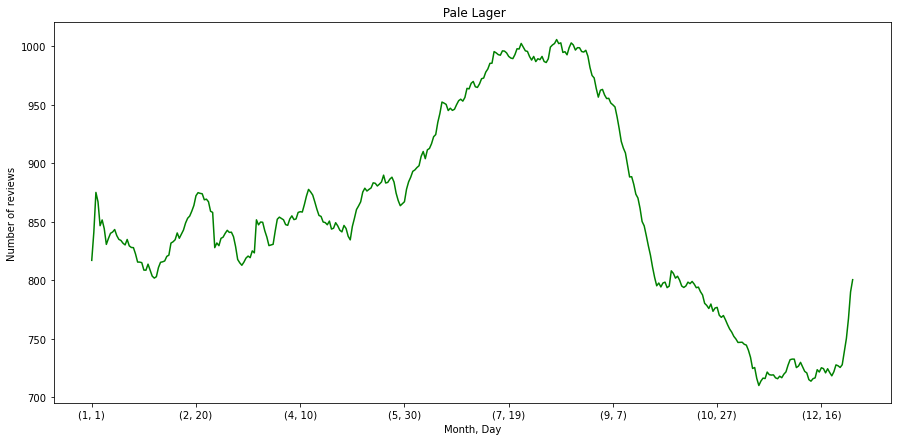

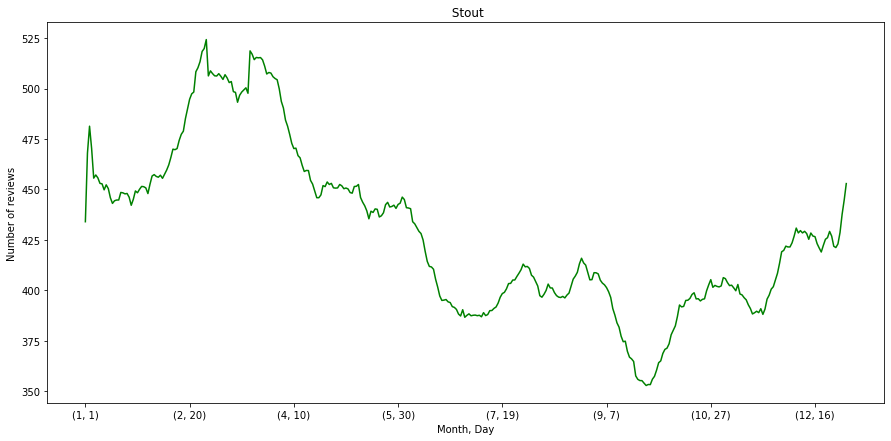

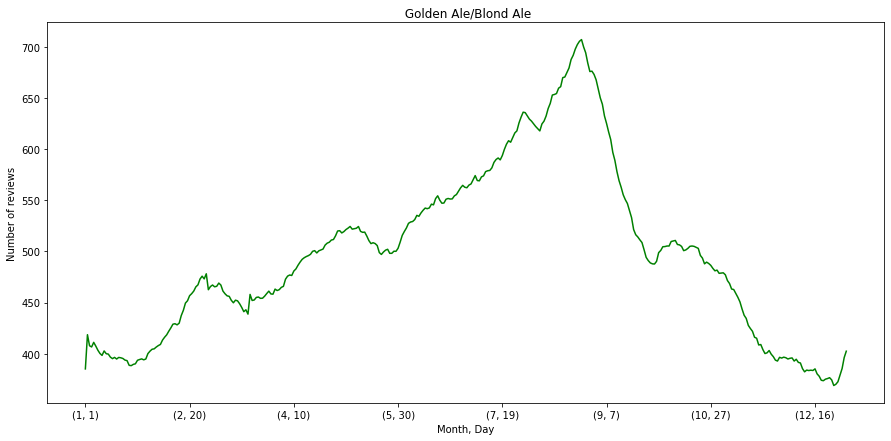

In [21]:
# RateBeer
for j in range(3):
    beer = review_rb[(review_rb['style'] == styles_rb[j])] # gets reviews of the given style
    
    # groups reviews of each years together day by day
    grouped = beer.groupby([beer['date'].dt.month, beer['date'].dt.day])['user_name'].count()
    grouped.rolling(20, min_periods=1).mean().plot() #moving average

plt.ylabel('Number of reviews')
plt.xlabel('Year, Month, Day')
plt.legend(styles_rb)
plt.title("Reviews through time grouped by months example")
plt.show()

From this plots it is possible to have a first idea of beer seasonality. The 'Golden Ale/Blond Ale' (the one just above) seems to have a larger consomption in july.
However it is hard to conclude anything as we do not know if this was a larger consumption repeting over the years or only a one year consumption.
We cannot compare seasonality of beers a such as it depends also on the means consumption of the beer.

<strong>We need another way to assess seasonality</strong>

## Second method: seasonal_decompose()
We used the existing function <strong>seasonal_decompose()</strong> to define a metric of seasonality using th following method on first beer styles and then on indivudual beers:
* group reviews per month
* if we have mode than two years values -> decompose Total_reviews = Trend x Seasonality + residues
 * Trend is a moving average of the Total_reviews
 * Seasonality is a periodic signal with a 1 year period that is obtained by a minimization problem
* Get the maximum value of the Seasonality signal -> it will be our seasonality metric

On top of that we filtered the data to remove certain non seasonal beers that would come out as seasonal threw this method (beers with little values)

More on the seasonal_decompose here: https://towardsdatascience.com/finding-seasonal-trends-in-time-series-data-with-python-ce10c37aa861

In [20]:
def seasonality(data,j,id_name, name,nbr_rev):
    
    output = pd.DataFrame(np.nan, index=[j], columns=[name,'max_month','max_season','min_month','min_season','nbr_review'])
    output[name] = id_name
    output['nbr_review'] = nbr_rev
    
    if len(data)<24: #remove data with less than 2 years values (returns NaN)
        return(output)
    
    else:
        #decompose seasonnality of reviews
        decompose_result_mult = seasonal_decompose(data, model="multiplicative", period=12)
        seasonal = decompose_result_mult.seasonal 
        trend = decompose_result_mult.trend
        
        #remove beers that have less than 10 reviews over their most reviewed month of the year
        max_review_per_month_year = pd.DataFrame(data).groupby(pd.Grouper(freq='1Y')).max().dropna()
        if sum(max_review_per_month_year[max_review_per_month_year<5].count())>0: #remove beers that have less than 5 reviews over their most reviewed month of the year
            return(output)
        
        # Maximum review period
        buffer_max = pd.DataFrame()
        largest_season = seasonal.nlargest(1, keep='all') #find max values
        buffer_max['date'] = largest_season.index  # find time 
        buffer_max['date'] = pd.to_datetime(buffer_max['date']) # convert
        output['max_month'] = buffer_max['date'].dt.month.median() #median of months
        output['max_season'] = seasonal.max()
            
        # Minimum review period
        buffer_min = pd.DataFrame()
        smallest_season = seasonal.nsmallest(1, keep='all') #find max values
        buffer_min['date'] = smallest_season.index  # find time
        buffer_min['date'] = pd.to_datetime(buffer_min['date']) # convert
        output['min_month'] = buffer_min['date'].dt.month.median() #median of months
        output['min_season'] = seasonal.min()
        
        return(output)

In [21]:
# build a seasonality df for values in data[criteria] == name 
# Allows to do it according to styles or beer_names

def build_seasonal_df(seasonal_df, name, data, criteria):

    for k in range(len(name)):
        unique_type = data[(data[criteria] == name[k])] # find reviews of following the criteria
        
        if criteria == 'beer_name': # use beer_id if criteria is beer_name
            index = int(unique_type['beer_id'].unique()[0]) 
        else: 
            index = k
            
        nbr_rev = len(unique_type) # number of review of individual beers/styles
        unique_type.set_index('date', inplace=True) 
        # groups and counts reviews per months
        unique_type = unique_type.groupby(pd.Grouper(freq='M'))['text'].count().reset_index(name='Count')
        
        # removing months of data with less than 10 review per months
        # if no months with more than 10 datas don't analyse seasonality
        n = unique_type.loc[unique_type['Count'] >= 10]
        if n.empty:
            continue
        unique_type = unique_type.iloc[n.index[0]:]
        
        # set names correctly for seasonal decomposition
        unique_type.rename(columns={'Count' :''}, inplace=True)
        unique_type.set_index('date', inplace=True)
        
        # removes months with 0 reviews and replace by 0.01 reviews to apply multiplicative decomposition
        unique_type.replace(0,0.01,inplace=True)
        
        seasonal = seasonality(unique_type, index, name[k], criteria, nbr_rev) #see function above
        seasonal_df = pd.concat([seasonal_df, seasonal], ignore_index=False)   #concat result with df

    return(seasonal_df)

### A. Style seasonality
style_season is the seasonality coefficient of each style

filtered_style_season is the actual styles that are seasonals

In [22]:
THRESHOLD_SEASON = 1.3; # criteria for sufficient seasonality coefficient obtained through iteration
THRESHOLD_REVIEW = 200; # criteria for sufficient reviews obtained through iteration

In [49]:
Months = ["January","February","March","April","May","June","July","August","Semptember","October","November","December"]

def get_seasonal_beers_types(dataset, *months):
    """get the type of beers having their strongest seasonality on the desired months

    Args:
        dataset (pd.DataFrame): a dataframe with the same shape as BA or RB

    Returns:
        pd.DataFrame: a dataframe with the computed beer' styles with their seasonality coefficients
    """
    #building the raw dataset with the seasonal trends
    style_season = pd.DataFrame(columns = ['style','max_month','max_season','min_month','min_season','nbr_review'])
    style_season = build_seasonal_df(style_season, dataset['style'].unique(), dataset, 'style')
    style_season = style_season.dropna()
    # reducing to the most seasonal parts with enough reviews to be considered
    filtered_style_season = style_season[style_season['max_season']>THRESHOLD_SEASON]
    filtered_style_season = filtered_style_season[filtered_style_season['nbr_review']>THRESHOLD_REVIEW]
    # computing seasonality for each desired month
    season_months = []
    for month in months:
        month_style = filtered_style_season[filtered_style_season['max_month'] == month].reset_index(drop=True)
        season_months.append(month_style)
        print(f"There are {month_style['style'].nunique()} style(s) of beer trendy in {Months[month-1]} in BeerAdvocate")
    
    return season_months
    

In [50]:
summer_style_ba, december_style_ba = get_seasonal_beers_types(review_ba,7,12)
summer_style_rb, december_style_rb = get_seasonal_beers_types(review_rb,7,12)

There are 9 style(s) of beer trendy in July in BeerAdvocate
There are 9 style(s) of beer trendy in December in BeerAdvocate


In [51]:
summer_style_ba.head(2)

,style,max_month,max_season,min_month,min_season,nbr_review
0,American Pale Wheat Ale,7.0,1.555531,11.0,0.632456,32292
1,Berliner Weissbier,7.0,1.736509,2.0,0.596644,13086
2,American Blonde Ale,7.0,1.458472,2.0,0.694745,21014
3,Hefeweizen,7.0,1.439033,12.0,0.728565,39101
4,Kölsch,7.0,1.502266,12.0,0.581092,13723


In [52]:
december_style_ba.head(2)

,style,max_month,max_season,min_month,min_season,nbr_review
0,Foreign / Export Stout,12.0,1.30032,9.0,0.8189,8952
1,Winter Warmer,12.0,3.7405,9.0,0.205049,26192
2,English Strong Ale,12.0,1.394851,6.0,0.814294,9295
3,Herbed / Spiced Beer,12.0,1.383885,3.0,0.868434,17657
4,American Strong Ale,12.0,1.359252,9.0,0.758867,41431


In [ ]:
summer_style_rb.head(2)

In [ ]:
december_style_rb.head(2)

### B. Indivudual beer seasonality
Let us now investigate if the beers of the trendy styles at a certain period are also trendy in that same period.

In [54]:
# This function iterates on every beers from a given list of styles to build a seasonal_df
# containing seasonality_coef and period of seasonality

def season_beer_from_style(styles, data, season_coef_limit, review_limit):
    seasonal_beer = pd.DataFrame(columns = ['beer_name','max_month','max_season','min_month','min_season','nbr_review'])

    for j in range(len(styles)):
        beer = data[(data['style'] == styles['style'][j])] # gets reviews of the given style
        names_beer = beer['beer_name'].unique() # get every unique name of beers from the style
        
        seasonal_beer = build_seasonal_df(seasonal_beer, names_beer, beer, 'beer_name')
            
    seasonal_beer = seasonal_beer.dropna()
    filtered_seasonal_beer = seasonal_beer[seasonal_beer['max_season']>season_coef_limit]
    filtered_seasonal_beer = filtered_seasonal_beer[filtered_seasonal_beer['nbr_review']>review_limit]
    print(f"There are {seasonal_beer['beer_name'].nunique()} beers of trendy styles in this data set")
    print(f"{filtered_seasonal_beer['beer_name'].nunique()} of them are considered seasonal")
    return filtered_seasonal_beer
    

<strong>BeerAdvocate:</strong>

In [55]:
xmas_seasonal_ba = season_beer_from_style(december_style_ba,review_ba,THRESHOLD_SEASON,THRESHOLD_REVIEW)
xmas_seasonal_ba.head()

There are 21 beers of trendy styles in this data set
11 of them are considered seasonal


,beer_name,max_month,max_season,min_month,min_season,nbr_review
577,Samuel Smith's Winter Welcome Ale,12.0,3.723452,8.0,0.081255,1155
1881,Samuel Adams Old Fezziwig Ale,12.0,4.004037,8.0,0.089006,1405
1576,Great Lakes Christmas Ale,12.0,4.556756,6.0,0.076634,880
86621,Not Your Father's Root Beer (5.9%),6.0,1.867442,3.0,0.231888,586
2264,Brown Shugga',1.0,2.605769,7.0,0.177826,1588


In the <strong>xmas_seasonal_ba</strong>, some beers have a higher seasonality coefficient in other months than december, so let's filtered them.

In [57]:
xmas_beers_ba = xmas_seasonal_ba[xmas_seasonal_ba['max_month'] == 12]
print(f"There are {xmas_beers_ba['beer_name'].nunique()} Chritmas beers in BeerAdvocate")
xmas_beers_ba.head()

There are 6 Chritmas beers in BeerAdvocate


,beer_name,max_month,max_season,min_month,min_season,nbr_review
577,Samuel Smith's Winter Welcome Ale,12.0,3.723452,8.0,0.081255,1155
1881,Samuel Adams Old Fezziwig Ale,12.0,4.004037,8.0,0.089006,1405
1576,Great Lakes Christmas Ale,12.0,4.556756,6.0,0.076634,880
7531,Tröegs The Mad Elf,12.0,3.301245,9.0,0.15003,1271
140,Corsendonk Christmas Ale,12.0,5.061932,10.0,0.132507,606


Let's do the same thing with the summer beers as a comparison.

In [60]:
summer_seasonal_ba = season_beer_from_style(summer_style_ba,review_ba,THRESHOLD_SEASON,THRESHOLD_REVIEW)
summer_beers_ba = summer_seasonal_ba[(summer_seasonal_ba['max_month'] == 7)
                                            |(summer_seasonal_ba['max_month'] == 8)]
print(f"There are {summer_beers_ba['beer_name'].nunique()} summer beers in BeerAdvocate")
summer_beers_ba.head()

There are 26 beers of trendy styles in this data set
16 of them are considered seasonal
There are 7 summer beers in BeerAdvocate


,beer_name,max_month,max_season,min_month,min_season,nbr_review
49789,A Little Sumpin' Sumpin' Ale,8.0,1.549728,11.0,0.635781,1674
35720,Festina Pêche,7.0,3.005077,2.0,0.310061,1365
49092,Oarsman Ale,7.0,1.749942,10.0,0.625464,638
113585,Hefeweizen,7.0,1.706209,11.0,0.569858,1885
3280,Schneider Weisse Tap 7 Unser Original,7.0,1.4746,12.0,0.679385,837


<strong>RateBeer:</strong> (computation is long so if already done one -> load pickle)

In [40]:
if os.path.isfile('Data/RateBeer/xmas_seasonal_rb.pkl')!=1: # Never computed ?
    xmas_seasonal_rb = season_beer_from_style(december_style_rb,review_rb,THRESHOLD_SEASON,THRESHOLD_REVIEW)[1]
    xmas_seasonal_rb.to_pickle('Data/RateBeer/xmas_seasonal_rb.pkl')
    
else: # Already computed
    xmas_seasonal_rb = pd.read_pickle('Data/RateBeer/xmas_seasonal_rb.pkl')
    print(f"There are {xmas_seasonal_rb['beer_name'].nunique()} seasonal beers of trendy styles at this period in this data set")
xmas_seasonal_rb.head()

There are 156 beers of trendy styles in this data set
85 of them are concidered seasonal


,beer_name,max_month,max_season,min_month,min_season,nbr_review
688,Flying Dog K-9 Winter Warmer,12.0,3.053216,10.0,0.379078,1025
26503,Innis & Gunn Original,8.0,1.303198,5.0,0.785322,1546
80407,Innis & Gunn Rum Cask,2.0,1.408393,9.0,0.674471,1204
231959,Innis & Gunn Toasted Oak IPA (Bottle),8.0,1.47473,12.0,0.662085,523
239634,Tennents Aged With Whisky Oak,8.0,1.870638,4.0,0.421624,263


In [42]:
xmas_beers_rb = xmas_seasonal_rb[xmas_seasonal_rb['max_month'] == 12]
print(f"There are {xmas_beers_rb['beer_name'].nunique()} Christmas beers in RateBeer")
xmas_beers_rb.head()

There are 31 Christmas beers in RateBeer


,beer_name,max_month,max_season,min_month,min_season,nbr_review
688,Flying Dog K-9 Winter Warmer,12.0,3.053216,10.0,0.379078,1025
95,Samuel Smiths Winter Welcome Ale,12.0,3.120188,8.0,0.232559,1701
79917,Shepherd Neame Christmas Ale,12.0,3.940617,7.0,0.122823,359
28663,Nøgne Ø God Jul,12.0,3.42311,7.0,0.353661,1054
114487,Fremont Abominable - Bourbon Barrel (B-Bomb),12.0,2.028566,11.0,0.371724,250


In [45]:
if os.path.isfile('Data/RateBeer/summer_beers_rb.pkl')!=1: # Never computed ?
    summer_beers_rb = season_beer_from_style(summer_style_rb,review_rb,THRESHOLD_SEASON,THRESHOLD_REVIEW)[1]
    summer_beers_rb.to_pickle('Data/RateBeer/summer_beers_rb.pkl')
    
else: # Already computed
    summer_beers_rb = pd.read_pickle('Data/RateBeer/summer_beers_rb.pkl')
    print(f"There are {xmas_seasonal_rb['beer_name'].nunique()} seasonal beers of trendy styles at this period in this data set")
xmas_seasonal_rb.head()

KeyboardInterrupt: 

In [ ]:
summer_beers_rb = summer_beers_rb[(summer_beers_rb['max_month'] == 7)
                                            |(summer_beers_rb['max_month'] == 8)]
print(f"There are {summer_beers_rb['beer_name'].nunique()} summer beers in RateBeer")
summer_beers_rb.head()

### C. Merging the datasets
To ease the work on the reviews for the sentiment analysis part, let's fuse the results of the seasonality study on the RateBeer and BeerAdvocate dataset.

In [ ]:
def season_plot(data, name):
    if len(data)>24:  # Removes styles that have less than 2 years review as it
                      # is needed for seasonal_decompose
            
        # seasonal_decompose uses a sine function and multiplies it to a trend
        # the trend is the general increase of the number of reviews
        # the seasonal highlights the periodicity of consumption of the beers
        # the residuals are the results of the difference of the trend*seasonality
        # High residuals means we cannot trust the model
        
        decompose_result_mult = seasonal_decompose(data, model="multiplicative", period=12)
        trend = decompose_result_mult.trend
        seasonal = decompose_result_mult.seasonal
        residual = decompose_result_mult.resid
        
        fig, axs = plt.subplots(4)
        fig.suptitle(name, fontsize=20)
        axs[0].plot(data, color='green')
        axs[0].set_xlabel('Year')
        axs[0].set_ylabel('Number of Reviews')
        axs[0].set_title('Daily reviews', fontsize=15)
        axs[1].plot(trend, color='green')
        axs[1].set_xlabel('Year')
        axs[1].set_ylabel('Number of Reviews')
        axs[1].set_title('Trend', fontsize=15)
        axs[2].plot(seasonal, color='green')
        axs[2].set_ylabel('Season coefficient')
        axs[2].set_xlabel('Year')
        axs[2].set_title('Seasonality', fontsize=15)
        axs[3].plot(residual, color='green')
        axs[3].set_xlabel('Year')
        axs[3].set_ylabel('Number of Reviews')
        axs[3].set_title('Residuals', fontsize=15)
        fig.tight_layout()

In [ ]:
def build_season_plot(name, data, criteria):

    for k in range(len(name)):
        unique_type = data[(data[criteria] == name[k])] # find reviews of following the criteria
        beer_name = unique_type[criteria].unique()[0]
        unique_type.set_index('date', inplace=True) 
        # groups and counts reviews per months
        unique_type = unique_type.groupby(pd.Grouper(freq='M'))['text'].count().reset_index(name='Count')
        
        # removing months of data with less than 10 review per months
        # if no months with more than 10 datas don't analyse seasonality
        n = unique_type.loc[unique_type['Count'] >= 10]
        if n.empty:
            continue
        unique_type = unique_type.iloc[n.index[0]:]
        
        # set names correctly for seasonal decomposition
        unique_type.rename(columns={'Count' :''}, inplace=True)
        unique_type.set_index('date', inplace=True)
        
        # removes months with 0 reviews and replace by 0.01 reviews to apply multiplicative decomposition
        unique_type.replace(0,0.01,inplace=True)
        
        seasonal = season_plot(unique_type, beer_name) #see function above
        

In [ ]:
# Getting names of all Xmas beers
names_xmas_ba = xmas_beers_ba.beer_name.unique()
names_xmas_rb = xmas_beers_rb.beer_name.unique()

names_xmas_rb = names_xmas_rb[~np.isin(names_xmas_rb,names_xmas_ba)] # remove duplicates
xmas_beers_name = np.concatenate([names_xmas_ba,names_xmas_rb])

In [ ]:
# regrouping Xmas reviews
xmas_reviews = pd.DataFrame()

for k in range(len(names_xmas_ba)): #from BA
        xmas_reviews_ba = review_ba[(review_ba['beer_name'] == names_xmas_ba[k])]
        xmas_reviews = pd.concat([xmas_reviews, xmas_reviews_ba], ignore_index=True)
        
for k in range(len(names_xmas_rb)): #from RB
        xmas_reviews_rb = review_rb[(review_rb['beer_name'] == names_xmas_rb[k])]
        xmas_reviews = pd.concat([xmas_reviews, xmas_reviews_rb], ignore_index=True)
        
print(f"There are {len(xmas_reviews)} Christmas beers reviews")
xmas_reviews.to_pickle('Data/xmas_reviews.pkl') #save to pkl for efficiency

In [ ]:
# Getting names of all summer beers
names_summer_ba = summer_beers_ba.beer_name.unique()
names_summer_rb = summer_beers_rb.beer_name.unique()

names_summer_rb = names_summer_rb[~np.isin(names_summer_rb,names_summer_ba)] # remove duplicates
summer_beers_name = np.concatenate([names_summer_ba,names_summer_rb])

In [50]:
# regrouping summer reviews
summer_reviews = pd.DataFrame()

for k in range(len(names_summer_ba)): #from BA
        summer_reviews_ba = review_ba[(review_ba['beer_name'] == names_summer_ba[k])]
        summer_reviews = pd.concat([summer_reviews, summer_reviews_ba], ignore_index=True)
        
for k in range(len(names_summer_rb)): #from RB
        summer_reviews_rb = review_rb[(review_rb['beer_name'] == names_summer_rb[k])]
        summer_reviews = pd.concat([summer_reviews, summer_reviews_rb], ignore_index=True)
        
print(f"There are {len(summer_reviews)} summer beers reviews")
summer_reviews.to_pickle('Data/summer_reviews.pkl') #save to pkl for efficiency

33541
33541


In [54]:
def build_seasonal_df2(seasonal_df, name, data, criteria):

    for k in range(len(name)):
        unique_type = data[(data[criteria] == name[k])] # find reviews of following the criteria
        
        
        index = k
            
        nbr_rev = len(unique_type) # number of review of individual beers/styles
        unique_type.set_index('date', inplace=True) 
        # groups and counts reviews per months
        unique_type = unique_type.groupby(pd.Grouper(freq='M'))['text'].count().reset_index(name='Count')
        
        # removing months of data with less than 10 review per months
        # if no months with more than 10 datas don't analyse seasonality
        n = unique_type.loc[unique_type['Count'] >= 10]
        if n.empty:
            continue
        unique_type = unique_type.iloc[n.index[0]:]
        
        # set names correctly for seasonal decomposition
        unique_type.rename(columns={'Count' :''}, inplace=True)
        unique_type.set_index('date', inplace=True)
        
        # removes months with 0 reviews and replace by 0.01 reviews to apply multiplicative decomposition
        unique_type.replace(0,0.01,inplace=True)
        
        seasonal = seasonality(unique_type, index, name[k], criteria, nbr_rev) #see function above
        seasonal_df = pd.concat([seasonal_df, seasonal], ignore_index=False)   #concat result with df

    return(seasonal_df)

In [ ]:
xmas_season = pd.DataFrame(columns = ['beer_name','max_month','max_season','min_month','min_season','nbr_review'])
xmas_season = build_seasonal_df2(xmas_season, xmas_beers_name, xmas_reviews, 'beer_name')
xmas_season.head()

In [ ]:
plt.rcParams["figure.figsize"] = (20,6)
plt.boxplot(xmas_season['max_season'])
plt.ylabel('Seasonality coefficient')
plt.title('Xmas beers')
plt.show()

plt.boxplot(xmas_season['nbr_review'])
plt.ylabel('Number of review')
plt.title('Xmas beers')
plt.show()

In [ ]:
# Bar Plot
plt.rcParams["figure.figsize"] = (20,15)
xmas_season.sort_values(['max_season'],ascending=True).plot.barh(x='beer_name',y='max_season', color='powderblue')
plt.ylabel('Beer name')
plt.xlabel('Seasonal coefficient')
plt.title('Seasonal coefficient of Xmas beers')
plt.show()

# Bar Plot
xmas_season.sort_values(['max_season'],ascending=True).plot.barh(x='beer_name',y='nbr_review', color='powderblue')
plt.ylabel('Beer name')
plt.xlabel('Number of reviews')
plt.title('Number of reviews of Xmas beers')
plt.show()

In [ ]:
summer_season = pd.DataFrame(columns = ['beer_name','max_month','max_season','min_month','min_season','nbr_review'])
summer_season = build_seasonal_df2(summer_season, summer_beers_name, summer_reviews, 'beer_name')
summer_season.head()

In [ ]:
plt.rcParams["figure.figsize"] = (20,6)
plt.boxplot(summer_season['max_season'])
plt.ylabel('Seasonality coefficient')
plt.title('Summer beers')
plt.show()

plt.boxplot(summer_season['nbr_review'])
plt.ylabel('Number of review')
plt.title('Summer beers')
plt.show()

In [ ]:
# Bar Plot
plt.rcParams["figure.figsize"] = (20,15)
summer_season.sort_values(['max_season'],ascending=True).plot.barh(x='beer_name',y='max_season', color='goldenrod')
plt.ylabel('Beer name')
plt.xlabel('Seasonal coefficient')
plt.title('Seasonal coefficient of Summer beers')
plt.show()

# Bar Plot
summer_season.sort_values(['max_season'],ascending=True).plot.barh(x='beer_name',y='nbr_review', color='goldenrod')
plt.ylabel('Beer name')
plt.xlabel('Number of reviews')
plt.title('Number of reviews of Summer beers')
plt.show()

## Sentiment analysis
In the <strong>Milestone 2</strong>, we observed that some beers have a marked seasonality. Many reviews contain words such as "summer", "winter", "autumn" or "spring", and we would like to push our analysis further :
* Are those reviews more positive or negative towards the mentioned seasons
* Can we grasp which words are used to qualify the beers in question, e.g does the beer feel warm, sour or bitter


We are looking for words appearing rather frequently to describe a beer which is trendy during Christmas time for example. For that reason, we will conduct an <strong>aspect-based sentiment analysis</strong>.

In order to do that, we will be looking at adjectives and their relative words to emphasize the beer's characteristics. That corresponds to <strong>adjectival modifiers</strong> mainly.

In [62]:
christmas_reviews = pd.read_pickle('Data/xmas_reviews.pkl')
summer_reviews = pd.read_pickle('Data/summer_reviews.pkl')

In [63]:
def analyze_sentiments(text: str) -> tuple([bool,list[str],list[str]]):
    """Analyze the review to determine wether it is positive or negative

    Args:
        text (str): The text to be analyzed

    Returns:
        sentiment: A boolean; true if the sentiment is positive, false otherwise
    """
    return nlp(text)._.blob.polarity > 0


In [64]:
# a small function to choose wich token should be kept as an aspect, and relevant for the description
selected = lambda token : True if (token.dep_ == "amod" or token.dep_=="compound") and (token.pos_ == "ADJ" or token.pos_=="ADV") else False

def get_aspects(text):
    """From several sentences, detect key aspects and their ajective qualifying the object in question

    Args:
        text (str): the text to be analyzed

    Returns:
        list (set): A list containing pairs of (aspect, description)
    """
    aspects = []
    for sentence in text.split("."):
        for token in nlp(sentence):
            # if (token.dep_ == "amod" or token.dep_=="compound") and (token.pos_ == "ADJ" or token.pos_=="NOUN"):
            if selected(token):
                aspects.append({'aspect': token.head.text, 'description': token})    
    # return {item['aspect'] for item in aspects}, {item['description'] for item in aspects} 
    return aspects

Let's build a dataframe regrouping the reviews of interest. This dataframe should contain :
* a boolean indicating if the review shows appreciation or not towards the beer *is_positive* : 1 for True, 0 otherwise
* a list of aspects characterising the beer, or the feeling of the reviewer *aspects*

In [65]:
def build_aspects_dataset(reviews, sentiment=True):
    """Take a pd.DataFrame reviews, and return a dataframe containing the aspects of the reviews' text

    Args:
        reviews (pd.DataFrame): Several reviews; each review must contain an id, style and a text.
        sentiment (boolean): Wether the analyzed reviews should be positive or negative toward the reviewed beer.

    Returns:
        pd.DataFrame: A dataframe containing the aspects involved in the reviews, with the words best qualifying them. 
    """

    # building a dataframe with the is_positive and the aspects
    df = pd.DataFrame()
    df[["beer_id","style"]] = reviews[["beer_id","style"]]
    tqdm.pandas(desc="Analyzing the reviews' sentiment")
    df["is_positive"] = reviews.text.progress_apply(lambda text: analyze_sentiments(text))
    df = df[df['is_positive']==True]
    tqdm.pandas(desc="Getting the reviews' aspects")
    df["aspects"] = reviews.text.progress_apply(lambda text: get_aspects(text))
    df.reset_index(inplace=True)
    # formatting the aspects in a more convenient way
    dicts = []
    for i in range(len(df)):
        new_dict = {item['aspect']:item['description'] for item in df["aspects"][i]}
        dicts.append(pd.DataFrame.from_dict(new_dict,columns=["descriptions"],orient="index"))
    # building a new dataframe with only the aspects and the descriptions
    aspects = pd.concat(dicts)
    aspects["aspects"] = aspects.index
    aspects["index_column"] = range(len(aspects))
    aspects.index = aspects["index_column"]
    # regrouping the aspects dataframe by aspects and merging the words describing them
    new_aspects = aspects.groupby('aspects')['descriptions'].apply(lambda x: ','.join(x.astype(str))).reset_index()
    # filtering weird aspect caught to avoid numbers and weird characters
    new_aspects["aspect_special"]=new_aspects['aspects'].apply(lambda x : True if re.search(r'[^a-zA-Z]+',x) else False)
    new_aspects = new_aspects[(new_aspects['aspect_special']==False)]
    # sorting the dataframe by the most described aspects
    new_aspects["descri_len"] = new_aspects["descriptions"].apply(lambda x: len(x.split(",")))
    new_aspects.sort_values(by="descri_len",ascending=False,inplace=True)
    new_aspects.reset_index(inplace=True)
    return new_aspects

In [ ]:
christmas_aspects = build_aspects_dataset(christmas_reviews)
summer_aspects = build_aspects_dataset(summer_reviews)

In [66]:
def top_characteristics(dataframe,nb_of_adjectives=3):
    """gives the top nb_of_characteristics for all aspects of the dataframe

    Args:
        dataframe (pd.DataFrame): the dataframe you want to extract the data from
        nb_of_adjectives (int, optional): the number of yielded adjectives. Defaults to 3.

    Returns:
        List: List with the top adjectives of each aspect
    """
    characteristics = []
    for i in range(len(dataframe)):
        MyList = [word.lower() for word in dataframe["descriptions"][i].split(',')] # splitting by words
        characteristics.append(sorted({i:MyList.count(i) for i in MyList}.items(),key=lambda x: x[1],reverse=True)[:nb_of_adjectives])
    return characteristics

def get_top_adjectives(dataframe,aspect,top=3):
    """Get the top adjectives of a certain aspect

    Args:
        dataframe (pd.DataFrame): the dataframe you want to extract the data from
        aspect (str): the aspect you want to consider
        top (int, optional): how much adjectives you want. Defaults to 3.

    Returns:
        List: the most used adjectives describing the aspect
    """
    try:
        target = dataframe[dataframe["aspects"]==aspect]
        adjectives = [word.lower() for word in target.descriptions.item().split(',')]
        sorted_top = sorted({i:adjectives.count(i) for i in adjectives}.items(),key=lambda x: x[1],reverse=True)[:top]
        return sorted_top
    except:
        raise ValueError("No such aspect identified in dataframe")
    

### Visualization

Next, we try to visualize what do the differences look like between the Christmas beers and the other ones.

In [67]:
def threshold(img):
    """Filter the beer's template image

    Args:
        img (np.array): the image to be filtered

    Returns:
        img_thresh (np.array): the filtered image
    """
    img_thres = img
    img_thres[ img < 50 ] = 0
    img_thres[ img >= 50 ] = 255
    return img_thres

def most_occuring_words(reviews, number = 100):
    """Form a list of the number-most occuring words in reviews

    Args:
        reviews (List): a list of string containing reviews 
        number (int, optional): How much words you want to keep. Defaults to 100.

    Returns:
        most_occur (List): list of the number-most occuring words in reviews
    """
    text = reviews.str.cat().lower().split()
    WCount = Counter(text)
    most_occur = WCount.most_common(number)
    most_occur = ([' '+word+' ' for word, word_count in most_occur])
    return most_occur
    
def plot_word_cloud(most_occur, title, number = 100):
    """Generates a word cloud with the words in most_occur

    Args:
        most_occur (List): the words to be plotted
        title (String): the plot's title
        number (int, optional): the number of words to plot. Defaults to 100.
    """
    mask = threshold(np.array(Image.open("./data/beer_contour.jpg").convert('L')))
    wordcloud = WordCloud(background_color="#ffffff", max_words=number, mask=mask,contour_color='#000000',contour_width=0,colormap='rainbow').generate(' '.join(most_occur))
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()
    
def filter_words(element,word):
    """a function to filter words occurences in element

    Args:
        element (String): An element to filter
        word (String): the word to be replaced

    Returns:
        String: the element object without the 'word' occurence.
    """
    return element.replace(word, " ")


Wordcloud for shuffled beers.

In [70]:
manual_remove = ['quot',',','.',':']
most_occur_all = most_occuring_words(review_ba['text'][0:120000], 150)
plot_word_cloud(most_occur_all, 'Most common words for all beers', 50)
for i in range(len(manual_remove)):
    most_occur_all.insert(0 , manual_remove[i])

FileNotFoundError: [Errno 2] No such file or directory: './data/beer_contour.jpg'

Wordcloud for Christmas beers.

In [ ]:
for word in most_occur_all:
    christmas_reviews.loc[:,'text'] = christmas_reviews['text'][:].apply(filter_words, args=(word,))
    
most_occur = most_occuring_words(christmas_reviews['text'])
plot_word_cloud(most_occur, 'Most common words for Christmas beers')

Wordcloud for summer beers.

In [ ]:
for word in most_occur_all:
    summer_reviews.loc[:,'text'] = summer_reviews['text'][:].apply(filter_words, args=(word,))
    
most_occur = most_occuring_words(summer_reviews['text'])
plot_word_cloud(most_occur, 'Most common words for summer beers')